In [1]:
from CollectMaPSAs import *
import cPickle
import matplotlib.pyplot as plt

ImportError: No module named CollectMaPSAs

In [6]:
mapsa_names = ["HPK_35494_042L"]

In [7]:
plt.rc('font', size=22, weight='bold')
plt.rc('axes', titlesize=22)#, labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=22)
plt.rc('figure', titlesize=22)

In [8]:
mapsas = []
for m in mapsa_names:
    # Read MaPSA object from file, if available
    fname = 'pickles/'+m+'.pkl'
    if os.path.isfile(fname):
        print("Loading MaPSA " + m)
        mapsa = cPickle.load(open(fname,'rb'))
    else: # Create it
        print("MaPSA " + m +" has no pickle")

    mapsas += [mapsa]

Loading MaPSA QP_no13


In [9]:
def scurve_plots(mapsas, whichcurve):

    print("Processing " + str(len(mapsas)) + " MaPSAs for S-curve plots")

    # CAL pre-trim
    df = pd.DataFrame([])
    for m in mapsas:
        for chip in m.mpa_chips:
            if whichcurve == "CAL_pretrim":
                df = chip.CALS_pretrim.transpose()[0:256]
            elif whichcurve == "CAL_posttrim":
                df = chip.CALS.transpose()[0:256]
            elif whichcurve == "THR_pretrim":
                df = chip.THRS_pretrim.transpose()[0:256]
            elif whichcurve == "THR_posttrim":
                df = chip.THRS.transpose()[0:256]
            elif whichcurve == "Bump":
                df = chip.BumpS.transpose()[0:256]
            
            df.plot(legend=False,figsize=(8,6))
            plt.xlabel('Units',fontweight='bold')
            plt.ylabel(whichcurve,fontweight='bold')
            plt.title(m.name+" MPA " + str(chip.index))
            plt.tight_layout()
            plt.savefig("scurves/"+m.name+"_"+str(chip.index)+"_"+whichcurve+"_Scurves.png",bbox_inches='tight')
            plt.savefig("scurves/"+m.name+"_"+str(chip.index)+"_"+whichcurve+"_Scurves.png",bbox_inches='tight')

            plt.show()

Processing 1 MaPSAs for S-curve plots


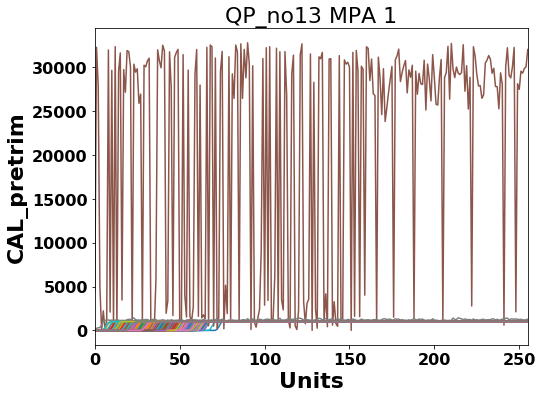

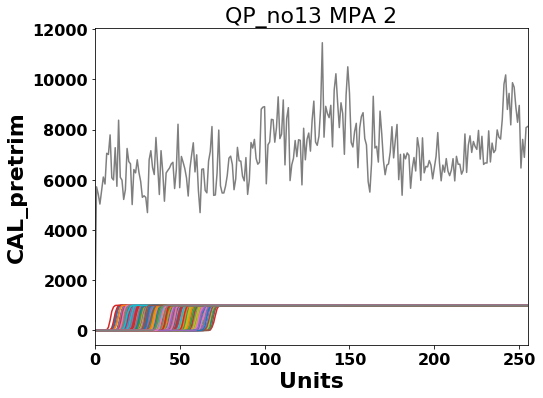

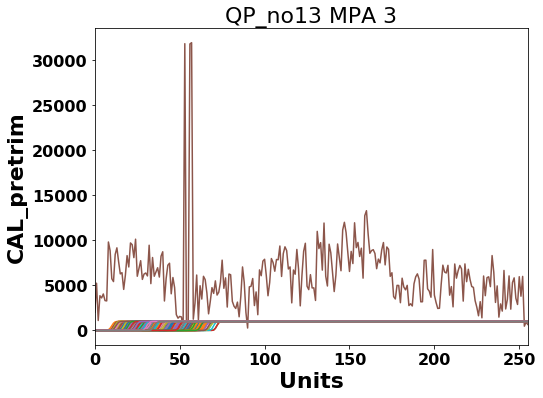

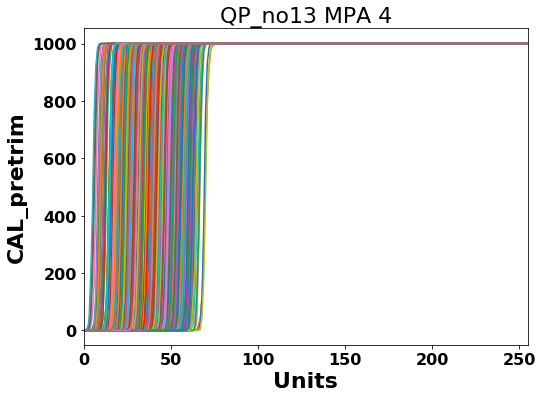

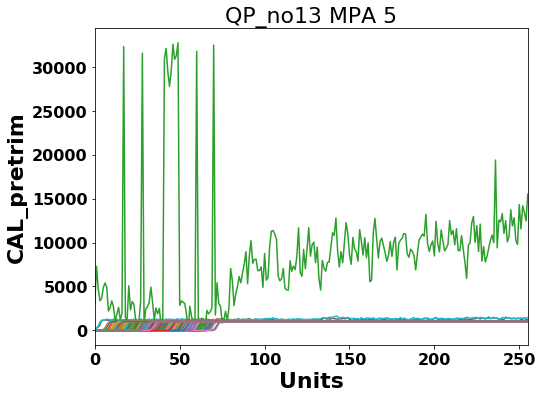

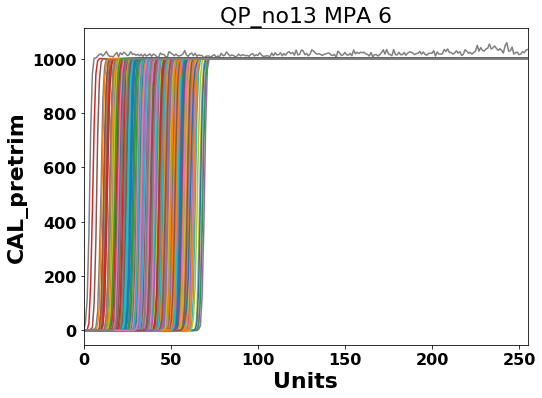

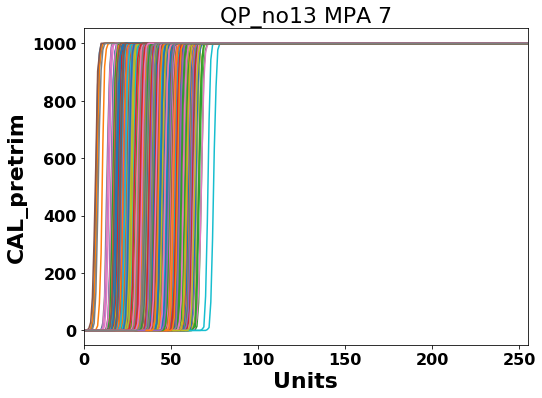

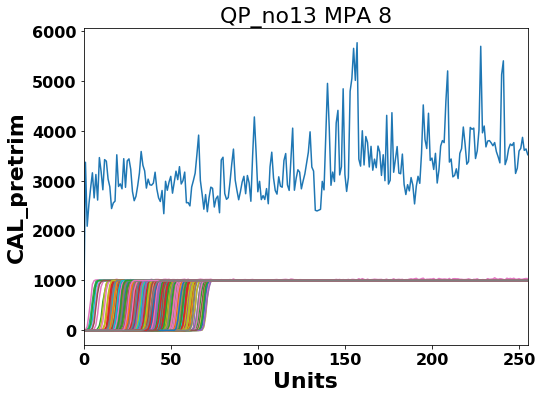

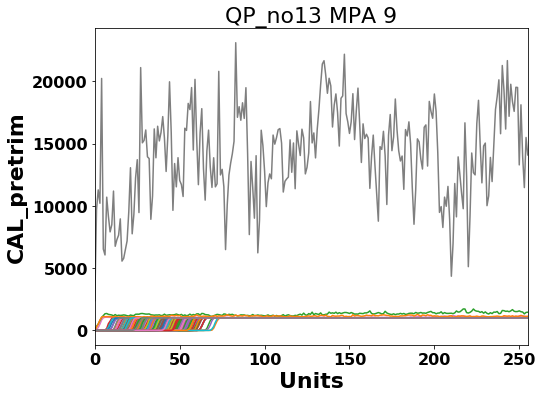

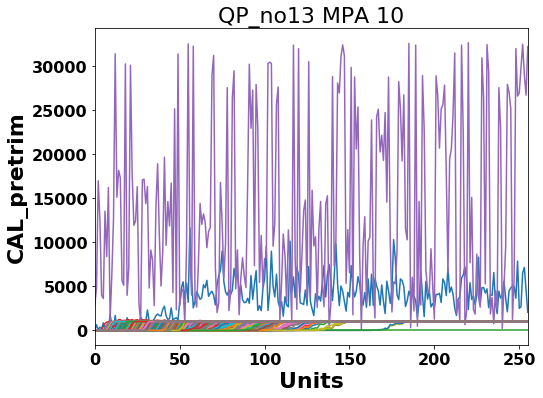

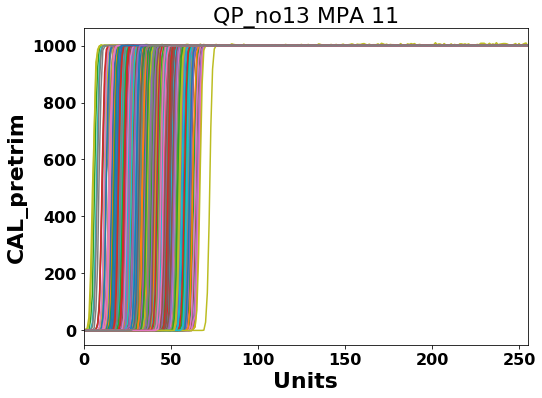

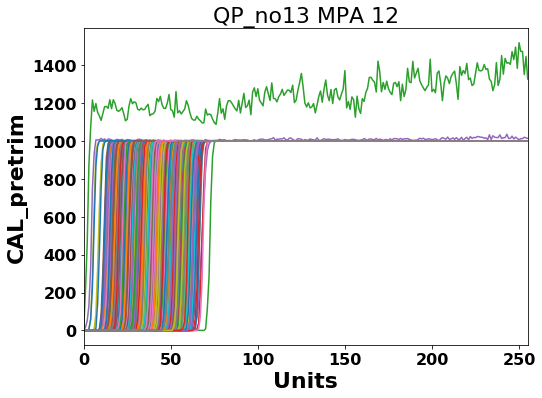

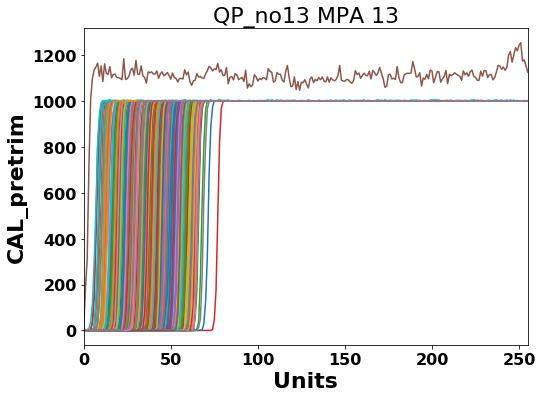

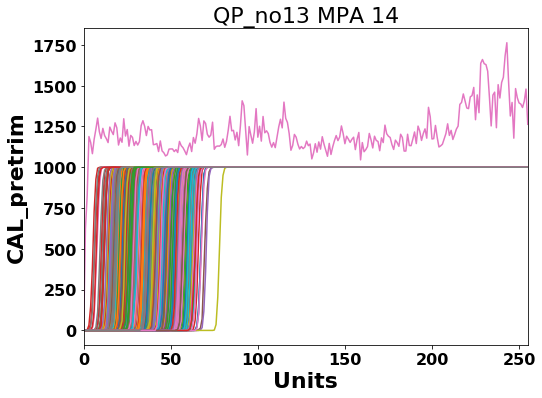

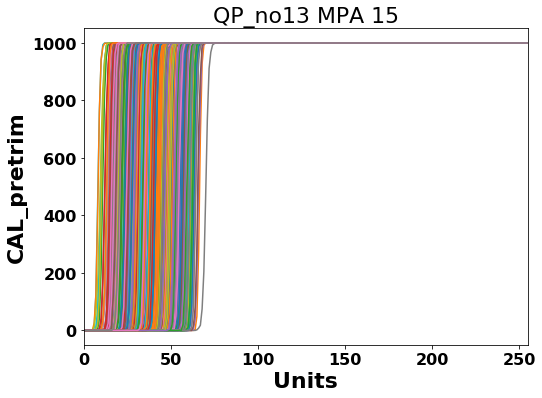

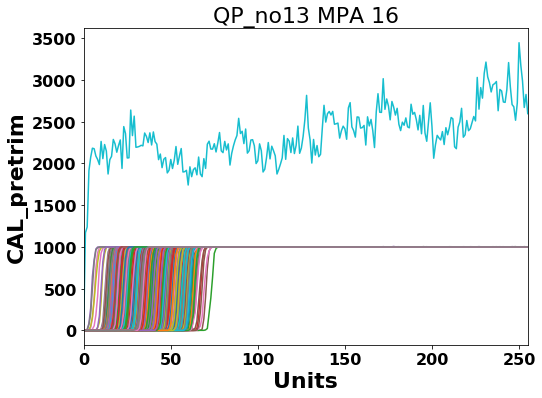

In [10]:
scurve_plots(mapsas,"CAL_pretrim")

Processing 1 MaPSAs for S-curve plots


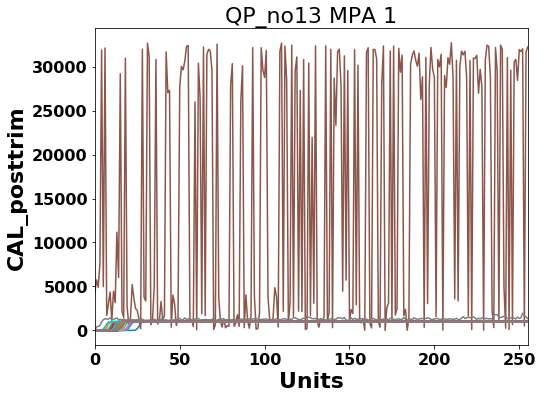

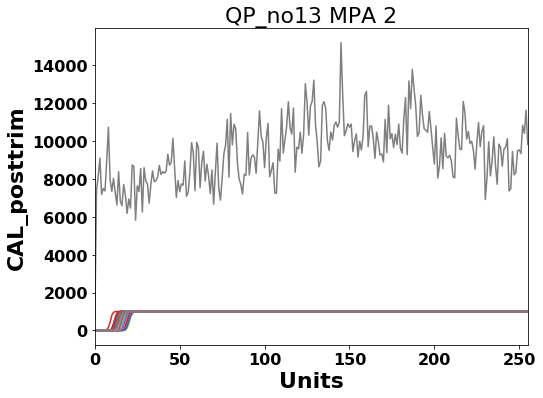

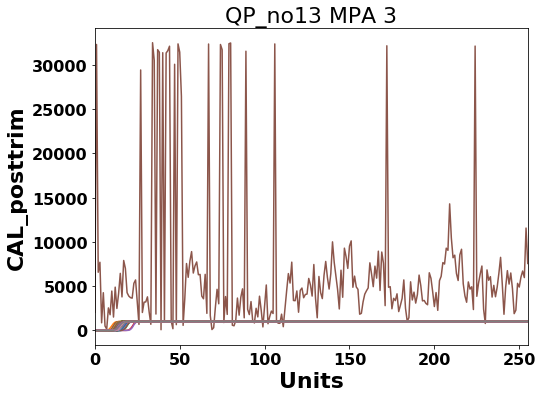

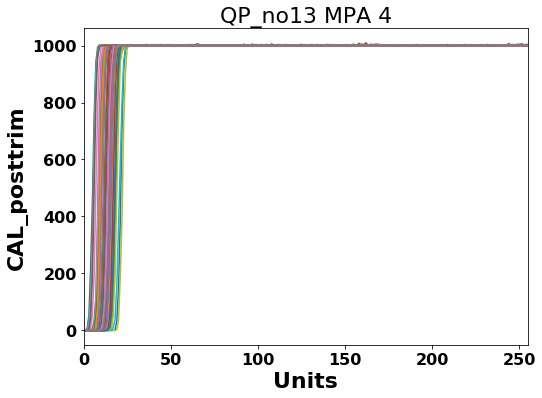

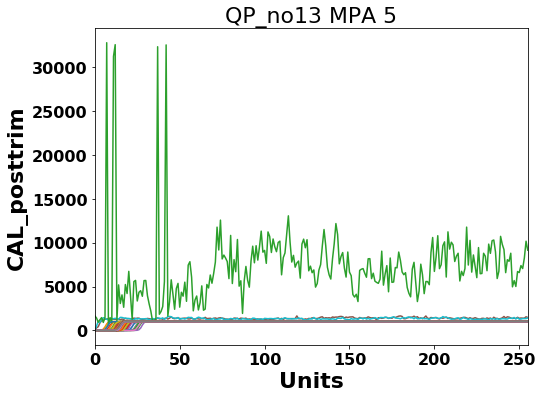

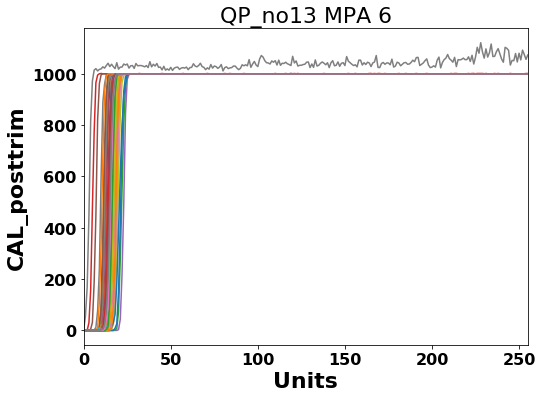

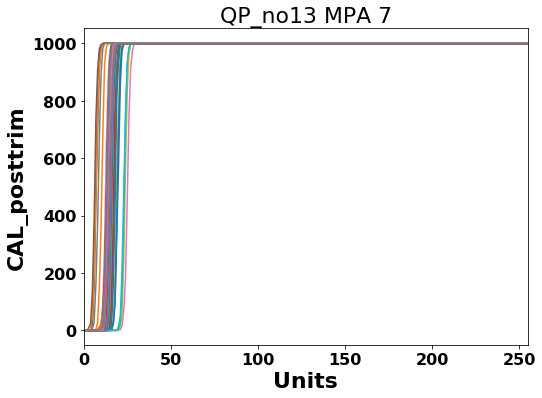

In [ ]:
scurve_plots(mapsas,"CAL_posttrim")

In [ ]:
scurve_plots(mapsas,"THR_pretrim")

In [ ]:
scurve_plots(mapsas,"THR_posttrim")

In [ ]:
scurve_plots(mapsas,"Bump")